In [1]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
import copy
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [2]:
device = torch.device("cuda")

In [3]:
os.getcwd()
print(os.listdir())

['Models', 'Audio Embedding - Wednesday 1.png', 'Arunachalam_Venkatachalam_HW5 - Try1 - Tuesday - Increase number of features.ipynb', 'New try - Thirsday.ipynb', 'Data', 'Predictions', '.vscode', 'Image Embedding - Wednesday 1.png', 'Best shot model.ipynb', 'Wed Try 2 Image Embedding.png', 'New try2 - Wednesday.ipynb', 'Arunachalam_Venkatachalam_HW5 - Try1 - Tuesday .ipynb', 'New try - Wednesday.ipynb', 'Wed Try 2 Audio Embedding.png', 'Image Embeddings.png', 'New try3 - Wednesday.ipynb', 'Arunachalam_Venkatachalam_HW5 - Try1 - Monday - Balancing Data.ipynb', 'Audio Embedding.png', 'New Try - Tuesday.ipynb', 'Arunachalam_Venkatachalam_HW5 - Try1 - Tuesday - Kernel size, removed all dropout layers.ipynb']


In [4]:
path = os.getcwd()
file_name = "Data"
correct_path = os.path.join(path, file_name)
os.chdir(correct_path)

In [5]:

print(os.listdir())

['y_train.csv', 'x_train_sp.npy', 'x_test_wr.npy', 'x_train_wr.npy', 'x_test_sp.npy']


In [6]:
audio_file = np.load('x_train_sp.npy')
print(audio_file.shape)
audio_file_reshaped = audio_file.reshape(60000,39,13)
print(audio_file_reshaped.shape)

# print(audio_file_reshaped[0])

(60000, 507)
(60000, 39, 13)


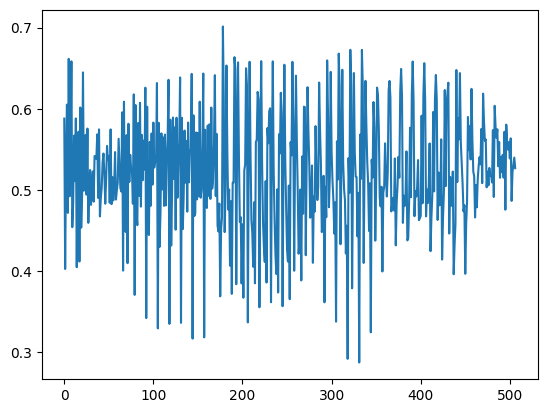

Max 0.7013475744631014
Min 0.28710884060411473
Max 0.7523583669326371
Min 0.26796116194632824
Max 0.7400421667938328
Min 0.2772044468118479
Max 0.6991743030435077
Min 0.2735765076753796
Max 0.7182367578242286
Min 0.2572728475588751
Max 0.7244582495077959
Min 0.3406768172624335
Max 0.6542020324550896
Min 0.2318609950179071
Max 0.7816513702152066
Min 0.3097046185139364
Max 0.6817581864716514
Min 0.3169556836024296
Max 0.7641186051559415
Min 0.24580676431207238
Max of all values:  1.0
Min of all values:  0.0


In [7]:
for i in range(0,1):
    plt.plot(audio_file[i])
    plt.show()

for i in range(0,10):
    print(f"Max {max(audio_file[i])}")
    print(f"Min {min(audio_file[i])}")

print("Max of all values: ", np.max(audio_file))
print("Min of all values: ", np.min(audio_file))

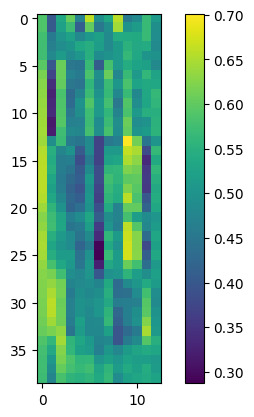

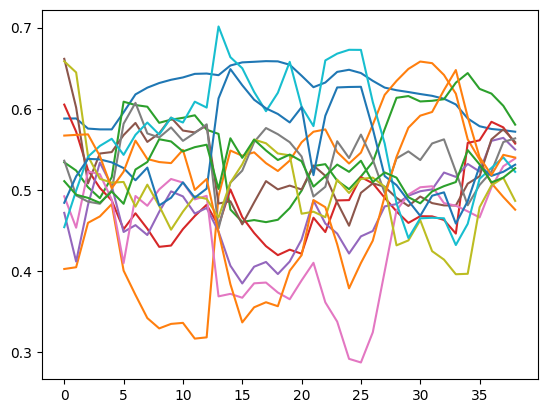

In [8]:
for i in range(0, 1):
    plt.figure()
    plt.imshow(audio_file_reshaped[i])
    #ax = plt.gca()  # Get the current axis
    #ax.invert_yaxis()
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.plot(audio_file_reshaped[i])
    plt.draw()

In [9]:
# print(audio_file[1])
# for i in range(len(audio_file)):
# Audio(data = audio_file[10], rate = 44100)
# Start playback

# audio = audio_file[4].astype(np.int16)
# play_obj = sa.play_buffer(audio, 1, 2, 44100)

# # Wait for playback to finish before exiting
# play_obj.wait_done()


# # Define the sampling rate (e.g., 22050 Hz for standard audio)
# sampling_rate = 22050

# # Convert the MFCC features back to audio
# audio_reconstructed = librosa.feature.inverse.mfcc_to_audio(audio_file)

# # Save the reconstructed audio as a WAV file
# librosa.output.write_wav('reconstructed_audio.wav', audio_reconstructed, sampling_rate)

# # Plot the reconstructed audio waveform
# plt.figure(figsize=(10, 4))
# librosa.display.waveshow(audio_reconstructed, sr=sampling_rate)
# plt.title('Reconstructed Audio Waveform')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.show()

In [10]:
dat = pd.read_csv('y_train.csv')
dat.head()
dat = dat.iloc[:,1:]
print(dat.head())
class_counts = dat['label'].value_counts().sort_index()
class_counts_dict = class_counts.to_dict()
total = class_counts.sum()
print(class_counts_dict)
print(total)

   label
0      7
1      3
2      4
3      6
4      1
{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
60000


In [11]:
# class_counts = [6742, 6265, 6131, 5958, 5949, 5923, 5918, 5851, 5842, 5421]
# total_samples = sum(class_counts)
# class_weights = {label: total_samples / (len(class_counts) * count) for label, count in enumerate(class_counts)}
# print(class_weights)

In [12]:
dat_array = dat.to_numpy()
dat_array = dat_array.squeeze()
weight_class_MNIST = compute_class_weight(class_weight="balanced", classes=np.unique(dat_array), y=dat_array)
weight_class_MNIST = weight_class_MNIST.astype(np.float32)
print(weight_class_MNIST)

[1.0130001  0.88994366 1.0070493  0.97863317 1.0270455  1.1068069
 1.013856   0.9577015  1.0254657  1.0085728 ]


In [13]:
class CustomDataLoaderAudioImage(Dataset):
    def __init__(self, data_path_audio, data_path_image, label_path = None, transform = None):
        self.train_data_audio = np.load(data_path_audio).astype(np.float32)
        self.train_data_audio = torch.from_numpy(self.train_data_audio)
        self.train_data_audio = self.train_data_audio.view(-1, 1, 507)  # Reshape to (batch_size, channels, length)
        self.train_data_image = np.load(data_path_image)
        self.train_data_image = self.train_data_image.reshape(-1,28,28)
        self.label_path = label_path
        if self.label_path is not None:
            self.data_path = pd.read_csv(label_path).iloc[:,1:].to_numpy()
            #self.data_path = torch.from_numpy(self.data_path)
            # self.data_path = self.data_path.view(-1, 1, 1)
        self.transform = transform

    def __len__(self):
        assert len(self.train_data_audio) == len(self.train_data_image)
        return len(self.train_data_audio)
    
    def __getitem__(self, idx):
        audio_data = self.train_data_audio[idx]
        image_data = self.train_data_image[idx]
        image_data = image_data.astype(np.float32)
        if self.label_path is not None:
            label_data = self.data_path[idx] 

        if self.transform:
            image_data = self.transform(image_data)

        # if self.label_path is not None:
        #     # Create TensorDataset
        #     combined_dataset = TensorDataset(audio_data, image_data, label_data)
        # else:
        #     combined_dataset = TensorDataset(audio_data, image_data)

        if self.label_path is not None:
            # Create TensorDataset
             return audio_data, image_data, label_data
        else:
            return audio_data, image_data
    
# class CustomDataLoaderImage(Dataset):
#     def __init__(self, data_path, label_path=None, transform=None):
#         self.train_data = np.load(data_path)
#         self.train_data = self.train_data.reshape(-1,28,28)
#         self.label_path = label_path
#         if self.label_path is not None:
#             self.train_label = pd.read_csv(label_path).iloc[:,1:].to_numpy()
#             # self.train_label = torch.from_numpy(self.train_label)
#             # self.train_label = self.train_label.view(-1, 1, 1)
#         self.transform = transform

#     def __len__(self):
#         return len(self.train_data)

#     def __getitem__(self, idx):
#         image = self.train_data[idx]
#         if self.label_path is not None:
#             label = self.train_label[idx] 
#         image = image.astype(np.float32)

#         if self.transform:
#             image = self.transform(image)

#         if self.label_path is not None:
#             return image, label
#         else:
#             return image

In [14]:
# customtransfromAudio = transforms.Compose([transforms.ToTensor()])
customtransfromImage = transforms.Compose([transforms.ToTensor()])

train_data_audio_image = CustomDataLoaderAudioImage(data_path_audio = 'x_train_sp.npy',
                                                    data_path_image= 'x_train_wr.npy',
                                                    label_path = 'y_train.csv',
                                                    transform= customtransfromImage)

# train_data_image = CustomDataLoaderImage(data_path= 'x_train_wr.npy',
#                                          label_path='y_train.csv',
#                                          transform= customtransfromImage)

test_data_audio_image = CustomDataLoaderAudioImage(data_path_audio='x_test_sp.npy',
                                                   data_path_image='x_test_wr.npy',
                                                    transform= customtransfromImage)

# test_data_image = CustomDataLoaderImage(data_path='x_test_wr.npy',
#                                         transform= customtransfromImage)


In [15]:
print(len(train_data_audio_image))
# print(len(train_data_image))

60000


In [16]:
total_size = len(train_data_audio_image)

# Calculate the sizes for training and validation sets
train_size = int(0.8 * total_size)
print(train_size)
val_size = total_size - train_size
print(val_size)

# Use random_split to split the dataset
train_dataset_audio_image, val_dataset_audio_image = random_split(train_data_audio_image, [train_size, val_size])
# train_dataset_image, val_dataset_image = random_split(train_data_image, [train_size, val_size])

train_loader_audio_image = DataLoader(dataset=train_dataset_audio_image,
                          batch_size=32,
                          shuffle=True,
                          num_workers=0)

val_loader_audio_image = DataLoader(dataset=val_dataset_audio_image,
                        batch_size=32,
                        shuffle=False,
                        num_workers=0)

# train_loader_image = DataLoader(dataset=train_dataset_image,
#                           batch_size=32,
#                           shuffle=True,
#                           num_workers=0)

# val_loader_image = DataLoader(dataset=val_dataset_image,
#                         batch_size=32,
#                         shuffle=False,
#                         num_workers=0)

test_loader_audio_image = DataLoader(dataset=test_data_audio_image,
                        batch_size=32,
                        shuffle=False,
                        num_workers=0)

# test_loader_image = DataLoader(dataset=test_data_image,
#                         batch_size=32,
#                         shuffle=False,
#                         num_workers=0)

#print(test_loader.shape)

48000
12000


In [17]:
# Get a batch of data from the data loader

data_iter_image_test = iter(test_loader_audio_image)
audio, images = next(data_iter_image_test)

print(f"Feature batch shape: {audio.size()}")
print(f"Feature batch shape: {images.size()}")
# print(f"Labels batch shape: {len(labels)}")

display = False

for i in range(len(images)):
  if display:
    # Convert image tensor to numpy array
    img_array = images[i].mul(255).cpu().numpy().squeeze(0)
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()
    plt.clf()

for i in range(len(audio)):
  if display:
    # Convert image tensor to numpy array
    audio_array = audio[i].cpu().numpy()
    # Reshape to have time steps on the x-axis and amplitude on the y-axis
    audio_array = audio_array.reshape(-1, 1)  # Assuming audio_array is a single channel
    plt.plot(audio_array)
    plt.axis()
    plt.show()
    plt.clf()

Feature batch shape: torch.Size([32, 1, 507])
Feature batch shape: torch.Size([32, 1, 28, 28])


In [18]:
# # Get a batch of data from the data loader

# data_iter_audio_test = iter(test_loader_audio)
# audio = next(data_iter_audio_test)

# print(f"Feature batch shape: {audio.size()}")
# # print(f"Labels batch shape: {len(labels)}")

# display = False

# for i in range(len(audio)):
#   if display:
#     # Convert image tensor to numpy array
#     audio_array = audio[i].cpu().numpy()
#     # Reshape to have time steps on the x-axis and amplitude on the y-axis
#     audio_array = audio_array.reshape(-1, 1)  # Assuming audio_array is a single channel
#     plt.plot(audio_array)
#     plt.axis()
#     plt.show()
#     plt.clf()

In [19]:
# Get a batch of data from the data loader

data_iter_image_train = iter(train_loader_audio_image)
audio, images, label = next(data_iter_image_train)
# print("Audio: ", audio)
# print("Images: ", images)
# print("Audio Squeezed: ", audio[:, :, 0,:])
# print("Audio Squeezed Size: ", audio[:,:,0,:].size())
print("Actual Labels: ", label)
print("Converted Labels: ", label.squeeze())
print(label[:,0])
print(f"Feature batch shape: {images.size()}")
print(f"Feature batch shape: {audio.size()}")
print(f"Labels batch shape: {label.size()}")

display = False

for i in range(len(images)):
  if display:
    print(f"Digit is: {label[i]}")
    # Convert image tensor to numpy array
    img_array = images[i].mul(255).cpu().numpy().squeeze(0)
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()
    plt.clf()

Actual Labels:  tensor([[3],
        [0],
        [9],
        [1],
        [8],
        [7],
        [8],
        [9],
        [2],
        [7],
        [8],
        [3],
        [8],
        [4],
        [6],
        [8],
        [5],
        [2],
        [6],
        [6],
        [5],
        [1],
        [8],
        [2],
        [8],
        [3],
        [2],
        [4],
        [2],
        [9],
        [3],
        [6]])
Converted Labels:  tensor([3, 0, 9, 1, 8, 7, 8, 9, 2, 7, 8, 3, 8, 4, 6, 8, 5, 2, 6, 6, 5, 1, 8, 2,
        8, 3, 2, 4, 2, 9, 3, 6])
tensor([3, 0, 9, 1, 8, 7, 8, 9, 2, 7, 8, 3, 8, 4, 6, 8, 5, 2, 6, 6, 5, 1, 8, 2,
        8, 3, 2, 4, 2, 9, 3, 6])
Feature batch shape: torch.Size([32, 1, 28, 28])
Feature batch shape: torch.Size([32, 1, 507])
Labels batch shape: torch.Size([32, 1])


In [20]:
# # Get a batch of data from the data loader

# data_iter_audio_train = iter(train_loader_audio)
# audio, label = next(data_iter_audio_train)

# print(audio)
# print(label.squeeze())
# print(f"Feature batch shape: {audio.size()}")
# print(f"Labels batch shape: {label.size()}")

# display = False

# for i in range(len(audio)):
#   if display:
#     # Convert image tensor to numpy array
#     print(f"Digit is: {label[i]}")
#     audio_array = audio[i].cpu().numpy()
#     # Reshape to have time steps on the x-axis and amplitude on the y-axis
#     audio_array = audio_array.reshape(-1, 1)  # Assuming audio_array is a single channel
#     plt.plot(audio_array)
#     plt.axis('off')
#     plt.show()
#     plt.clf()

In [21]:
import torch.nn as nn
import torch.nn.functional as F

In [22]:
# def conv1d_output_size(input_size, out_channels, padding, kernel_size, stride, dilation=None):
#     """According to https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
#     """
#     if dilation is None:
#         dilation = 1

#     output_size = (
#         out_channels,
#         np.floor((input_size[1] + 2 * padding - dilation *
#                   (kernel_size - 1) - 1) / stride + 1).astype(int)
#     )
#     return output_size


# c_i = 1 
        # c_o1 = [32,64]
        # c_o2 = [64,128]
        # k = [3,5] 
        # s = [1,2]
        # padding = 'same'
        # print(f"Conv kernel parameters: c_i={c_i}, c_o={c_o}, k={k}, s={s}, p={p}")

In [23]:
# class CNNAudioModel(nn.Module):
#     def __init__(self):
#         super(CNNAudioModel, self).__init__()
#         self.Conv1 = nn.Conv1d(1, 32, kernel_size=3, padding= 1)
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.Conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
#         self.flatten = nn.Flatten()

#         # Fully connected layers:
#         self.fc1 = nn.Linear(in_features=self.get_feature_dim(), out_features=128)  # Adjust output size
#         self.dropout = nn.Dropout(p=0.2)  # Add dropout for regularization (optional)
#         self.fc2 = nn.Linear(128, 10)  # Output layer with num_classes neurons

#     def get_feature_dim(self):
#         # Calculate the output dimension after flattening based on input shape
#         dummy_input = torch.randn(32, 1, 507)  # Assuming input shape (batch_size, channels, audio_length)
#         output = self.flatten(self.pool(self.Conv2(self.pool(self.Conv1(dummy_input)))))
#         return output.shape[1]   # Get the number of features after flattening

#     def forward(self, x):
#         x = self.relu(self.pool(self.Conv1(x)))
#         x = self.relu(self.pool(self.Conv2(x)))
#         x = self.flatten(x)
#         x = self.dropout(self.relu(self.fc1(x)))  # ReLU activation and dropout
#         x = self.fc2(x)
#         return F.softmax(x, dim=1)

In [24]:
# class AudioClassifier(nn.Module):
#   def __init__(self, num_classes, sample_rate, in_channels=1):
#     super(AudioClassifier, self).__init__()
#     # Define convolutional layers
#     self.conv1 = nn.Conv1d(in_channels, num_filters, kernel_size=3, stride=1, padding=1)
#     self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
#     self.conv2 = nn.Conv1d(8, 16, kernel_size=3, stride=1, padding=1)
#     self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
#     # Flatten layer
#     self.flatten = nn.Flatten()
#     # Fully connected layers
#     self.fc1 = nn.Linear(16 * ((sample_rate // 4) // 2), 32)
#     self.fc2 = nn.Linear(32, num_classes)

#   def forward(self, x):
#     # Apply activation after each convolutional layer
#     x = F.relu(self.conv1(x))
#     x = self.pool1(x)
#     x = F.relu(self.conv2(x))
#     x = self.pool2(x)
#     # Flatten the data
#     x = self.flatten(x)
#     # Fully connected layers
#     x = F.relu(self.fc1(x))
#     x = self.fc2(x)
#     # Output layer with softmax for classification
#     output = F.softmax(x, dim=1)
#     return output

In [25]:
# class CNNAudioModel(nn.Module):
#   def __init__(self, num_conv_layers, num_filters, kernel_size, dropout_rate):
#     super(CNNAudioModel, self).__init__()
#     c_i = 1  # Input channels (mono audio)

#     # Define a list of channels for each convolutional layer
#     c_o = [num_filters] * num_conv_layers  # Assuming same filters for all layers (modify if desired)

#     # Define a list of kernel sizes
#     k = kernel_size * num_conv_layers  # Assuming same kernel size for all layers (modify if desired)
#     k = list(k)  # Convert to list for individual access

#     # Define a list of strides
#     s = [1] * num_conv_layers  # Assuming stride 1 for all layers (modify if desired)

#     # Define padding scheme
#     padding = 'same'

#     # Print kernel parameters (useful for debugging and understanding)
#     print(f"Conv kernel parameters: c_i={c_i}, c_o={c_o}, k={k}, s={s}, p={padding}")

#     # Create the convolutional layers
#     self.conv_layers = nn.ModuleList([])
#     for i in range(num_conv_layers):
#       self.conv_layers.append(nn.Conv1d(c_i, c_o[i], k[i], padding=padding))
#       c_i = c_o[i]  # Update input channels for next layer

#     # Add dropout layer (optional)
#     self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

#     # Create the pooling layer (optional)
#     self.pooling = nn.MaxPool1d(kernel_size=2)  # Adjust kernel size as needed

#     # Define the final fully connected layer(s) for classification
#     self.fc1 = nn.Linear(c_o[-1], 128)  # You can adjust the number of neurons in the hidden layer
#     self.fc2 = nn.Linear(128, num_classes)  # Replace num_classes with your actual number of output classes

#   def forward(self, x):
#     # Pass the input through convolutional layers
#     for layer in self.conv_layers:
#       x = layer(x)
#       x = nn.functional.relu(x)  # Apply activation (e.g., ReLU)

#     # Optional: Apply dropout
#     if self.dropout is not None:
#       x = self.dropout(x)

#     # Optional: Apply pooling
#     x = self.pooling(x)

#     # Flatten the output for fully connected layers
#     x = x.view(x.size(0), -1)

#     # Pass through fully connected layers
#     x = nn.functional.relu(self.fc1(x))
#     x = self.fc2(x)

#     # Apply softmax for probability distribution (classification tasks)
#     return nn.functional.softmax(x, dim=1)


In [26]:
class AudioImageModel(nn.Module):
    def __init__(self, num_classes=10):
        super(AudioImageModel, self).__init__()

        # Image Processing (Custom block)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.get_image_feature_dim(), 64)  # Adjust output size
        #self.fc2 = nn.Linear(128, 64)  # Adjust output size

        # Audio Processing (Similar to previous version)
        self.conv1_audio = nn.Conv1d(1, 32, kernel_size=7, stride=1, padding = 3)
        self.pool_audio = nn.MaxPool1d(kernel_size=3, stride = 1, padding = 1)
        self.conv2_audio = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding = 2)
        self.conv3_audio = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding = 1)
        self.relu = nn.ReLU()
        self.fc1_audio = nn.Linear(self.get_audio_feature_dim(), 128)  # Adjust based on calculated output size
        self.fc2_audio = nn.Linear(128, 64)

        # Classification Head
        #self.fc_final_1 = nn.Linear(128, 64)
        self.fc_final_2 = nn.Linear(128, num_classes)
        self.bn = nn.BatchNorm1d(128)

    def get_image_feature_dim(self):
        # Calculate the output dimension after flattening based on image input shape
        dummy_input = torch.randn(32, 1, 28, 28)  # Assuming image size 28x28
        output = self.pool2(self.conv3(self.pool2(self.conv2(self.pool1(self.conv1(dummy_input))))))
        return output.size(1) * output.size(2) * output.size(3)
        
    def get_audio_feature_dim(self):
        # Calculate the output dimension after flattening based on audio input shape
        dummy_input = torch.randn(32, 1, 507)  # Assuming audio_length=507
        d1 = self.conv1_audio(dummy_input)
        #rint(d1.shape)
        d2 = self.conv2_audio(dummy_input)
        #print(d2.shape)
        d3 = self.conv3_audio(dummy_input)
        #print(d3.shape)
        output = self.flatten(torch.cat((d1, d2, d3), dim=1))
        #print("Inside Loop:", output.shape)
        return output.shape[1]

    def forward(self, audio, image):
        # for audio, image,_ in dataload:
        #print("Image Inputs: ", image)
        # Image Processing
        x_image = self.relu(self.pool1(self.conv1(image)))
        x_image = self.relu(self.pool2(self.conv2(x_image)))
        x_image = self.dropout(x_image)
        x_image = self.relu(self.pool2(self.conv3(x_image)))
        x_image = torch.flatten(x_image, 1)
        x_image = (self.fc1(x_image))
        image_embedding = x_image
        x_image = self.relu(x_image)
        x_image = self.dropout(x_image)
        #x_image = self.fc2(x_image)
        x_image = self.relu(x_image)
        #x_image = self.dropout(x_image)
        #print("Audio Size: ", audio.size())
        # Audio Processing
        # audio_reshaped = audio[:,:,0,:]
        #print("Audio Inputs: ", audio)
        x_audio_1 = self.conv1_audio(audio)
        x_audio_2 = self.conv2_audio(audio)
        x_audio_3 = self.conv3_audio(audio)
        x_audio = torch.cat((x_audio_1, x_audio_2, x_audio_3), dim=1)
        #print("After concat", x_audio.shape)
        # x_audio = self.pool_audio(self.relu(self.conv1_audio(audio)))
        # print(x_audio.size())
        x_audio = self.pool_audio((x_audio))
        #print("After Max pooling:", x_audio.shape)
        x_audio = self.relu(x_audio)
        #print("After relu:", x_audio.shape)
        x_audio = self.dropout(x_audio)
        #print("After dropout", x_audio.shape)
        x_audio = x_audio.view(-1, self.get_audio_feature_dim())
        #print(x_audio.shape)  # Dynamic feature dim calculation #64*251
        x_audio = self.relu(self.fc1_audio(x_audio))
        x_audio = self.dropout(x_audio)
        x_audio = self.fc2_audio(x_audio)
        audio_embedding = x_audio
        x_audio = self.relu(x_audio)
        #x_audio = self.dropout(x_audio)
        # print(x_audio.size())

        # Combine features
        combined_features = torch.cat((x_image, x_audio), dim=1)
        combined_features = self.bn(combined_features)

        # Final classification
        output = self.fc_final_2(combined_features)
        #output = self.dropout(output)
        #output = self.fc_final_2(output)
        output = F.softmax(output, dim=1)
        return output, image_embedding, audio_embedding


In [27]:
cnn = AudioImageModel()
print(cnn)

AudioImageModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1152, out_features=64, bias=True)
  (conv1_audio): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (pool_audio): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (conv2_audio): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3_audio): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1_

In [28]:
# Assuming weight_class_MNIST is an ndarray
weight_class_MNIST_tensor = torch.from_numpy(weight_class_MNIST)
print(weight_class_MNIST_tensor)

# Now use it in nn.CrossEntropyLoss
loss_func = nn.CrossEntropyLoss(weight=weight_class_MNIST_tensor)
loss_func

tensor([1.0130, 0.8899, 1.0070, 0.9786, 1.0270, 1.1068, 1.0139, 0.9577, 1.0255,
        1.0086])


CrossEntropyLoss()

In [29]:
from torch import optim

optimizer = optim.Adam(cnn.parameters(), lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [30]:
# class ModelTrainandVal:
#     def __init__(self, model, train_data, val_data, loss_func, optimizer, num_epochs = 30):
#         self.model = model
#         self.train_data = train_data
#         self.val_data = val_data
#         self.loss_func = loss_func
#         self.optimizer = optimizer
#         self.num_epochs = num_epochs

#     def train_model_audio(self):
#         train_losses = []
#         train_accuracies = []
#         val_losses = []
#         val_accuracies = []
#         for epoch in range(self.num_epochs):
#             self.model.train()
#             running_loss = 0.0
#             correct = 0
#             total = 0
#             for inputs, labels in self.train_data:
#                 self.optimizer.zero_grad()
#                 outputs = self.model(inputs)
#                 loss = self.loss_func(outputs, labels.squeeze())
#                 loss.backward()
#                 self.optimizer.step()
#                 running_loss += loss.item() * inputs.size(0)
#                 _, predicted = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#             epoch_loss = running_loss / len(self.train_data.dataset)
#             epoch_accuracy = correct / total
#             train_losses.append(epoch_loss)
#             train_accuracies.append(epoch_accuracy)

#             print(f"Epoch [{epoch+1}/{self.num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")

#             self.evaluate_model()

#     def evaluate_model(self):
#         self.model.eval()  # Set the model to evaluation mode
#         val_loss = 0.0
#         correct = 0
#         total = 0
#         with torch.no_grad():  # Disable gradient calculation for efficiency
#             for inputs, labels in self.val_data:
#                 outputs = self.model(inputs)
#                 loss = loss_func(outputs, labels.squeeze())
#                 val_loss += loss.item() * inputs.size(0)
#                 _, predicted = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         epoch_loss = val_loss / len(self.val_data.dataset)
#         epoch_accuracy = correct / total

#         print(f"Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_accuracy:.4f}")
#         return epoch_loss, epoch_accuracy


In [31]:
# device = torch.device("cuda")

In [32]:
class ModelTrainandVal:
    def __init__(self, model, train_data_audio_image, val_data_audio_image, loss_func, optimizer, num_epochs=100):
        self.model = model
        self.train_data_audio_image = train_data_audio_image
        self.val_data_audio_image = val_data_audio_image
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.num_epochs = num_epochs 
        # self.precision_metric = Precision(task ="multiclass" ,num_classes=10)
        # self.recall_metric = Recall(task="multiclass", num_classes=10)
        self.best_epoch = None  # Track epoch with best F1 score
        self.val_accuracy = 0.0  # Initialize best F1 score
        self.best_model_state = None  # Store best model stat
        self.image_embeddings = None
        self.audio_embeddings = None
        self.image_embeddings_all = []
        self.audio_embeddings_all = []
        self.best_image_embeddings = None
        self.best_audio_embeddings = None

    def save_embeddings(self, embeddings, filename):
        with open(filename, 'wb') as f:
            torch.save(embeddings, f)

    def visualize_embeddings(self, embeddings, labels, title):
        if embeddings is None:
            return
        tsne = TSNE(n_components=2, random_state=0)
        embeddings_tsne = tsne.fit_transform(embeddings.detach().numpy())
        kmeans = KMeans(n_clusters=10, random_state=0)
        cluster_labels = kmeans.fit_predict(embeddings.detach().numpy())
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster_labels, cmap='tab10')
        plt.colorbar(scatter)
        plt.title(title)
        plt.show()

    def train_model(self):
        train_losses = []
        train_accuracies = []
        batch_losses = []
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Iterate through audio and image data together using zip
            for audio_inputs, image_inputs, labels in self.train_data_audio_image:
                self.optimizer.zero_grad()
                # Combine audio and image data before feeding to the model
                #combined_inputs = self.load_data_train(audio_inputs, image_inputs, labels)
                #combined_inputs = torch.cat((audio_inputs, image_inputs), dim=1)
                #print("Image: ", image_inputs)
                # print("Audio: ", audio_inputs)
                #print("Labels: ", labels)
                # aud_inputs = audio_inputs.to(device)
                # ima_inputs = image_inputs.to(device)
                outputs, image_embedding, audio_embedding = self.model(audio_inputs, image_inputs)
                #print("Outputs: ", outputs)
                loss = self.loss_func(outputs, labels.squeeze())
                loss.backward()
                self.optimizer.step()
                #print(f"Audio input size {audio_inputs.size(0)} and Image inputs size {image_inputs.size(0)}")
                running_loss += loss.item() * len(audio_inputs) #audio_inputs.size(0) #(audio_inputs.size(0) + image_inputs.size(0))
                batch_losses.append(loss.item())
                #print("Running Loss:" ,running_loss)
                _, predicted = torch.max(outputs, 1)
                #print("Predicted: ", predicted)
                #print("Labels: ", labels.squeeze())
                #print("Predicted is: ", predicted)
                #print("labels size: ", labels.size(0))
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
                # Calculate metrics using torchmetrics
                # self.precision_metric(predicted, labels.squeeze())
                # self.recall_metric(predicted, labels.squeeze())
                #print(correct)

            # self.precision_metric.update()
            # self.recall_metric.update()

            epoch_loss = sum(batch_losses) / len(batch_losses)
            epoch_accuracy = correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)

            print(f"Epoch [{epoch+1}/{self.num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")

            # # Calculate additional metrics
            # precision = self.precision_metric.compute()
            # recall = self.recall_metric.compute()
            # f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')

            # print(f"F1 Score Training: {f1:.4f}")
            # print(f"Precision Training: {precision:.4f}")
            # print(f"Recall Training: {recall:.4f}")

            # # Reset metrics for next epoch
            # self.precision_metric.reset()
            # self.recall_metric.reset()

            accuracy_val = self.evaluate_model()

            # Update best model state if F1 score improves
            if accuracy_val > self.val_accuracy:
                self.best_epoch = epoch + 1
                self.val_accuracy = accuracy_val
                self.best_model_state = copy.deepcopy(self.model.state_dict())
                self.best_image_embeddings = image_embedding
                self.best_audio_embeddings = audio_embedding

            self.store_all_embedding(image_embedding, audio_embedding)

        print(f"Finished Training. Best Accuracy: {self.val_accuracy:.4f} at Epoch {self.best_epoch}")

        # Save the best model state
        if self.best_model_state is not None:
            torch.save(self.best_model_state, '../Models/model_high_best_1.pt')  # Save to 'best_model.pt' file

        # Visualize embeddings
        labels = [label for _, _, label in self.train_data_audio_image]
        # print(label)
        # print(labels)
        self.visualize_embeddings(torch.cat(self.image_embeddings_all), labels, 'Image Embeddings')
        self.visualize_embeddings(torch.cat(self.audio_embeddings_all), labels, 'Audio Embeddings')

    def store_all_embedding(self, image_embedding, audio_embedding):
        if image_embedding is not None:
            self.image_embeddings_all.append(image_embedding)
        if audio_embedding is not None:
            self.audio_embeddings_all.append(audio_embedding)

        # # Apply kmeans clustering
        # kmeans_image = KMeans(n_clusters=10, random_state=0).fit(self.image_embeddings)
        # kmeans_audio = KMeans(n_clusters=10, random_state=0).fit(self.audio_embeddings)

    def evaluate_model(self):
        self.model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_losses = []
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient calculation for efficiency
            for audio_inputs, image_inputs, labels in self.val_data_audio_image:
                #combined_inputs = TensorDataset(image_inputs, audio_inputs, labels)
                #combined_inputs = torch.cat((audio_inputs, image_inputs), dim=1)
                #combined_inputs= self.load_data_train(audio_inputs, image_inputs, labels)
                #print("Image: ", image_inputs)
                #print("Audio: ", audio_inputs)
                #print("Labels: ", labels)
                # aud_inputs = audio_inputs.to(device)
                # ima_inputs = image_inputs.to(device)
                outputs, _, _ = self.model(audio_inputs, image_inputs)
                loss = self.loss_func(outputs, labels.squeeze())
                #print("Labels: ", labels.squeeze())
                val_loss += loss.item() * len(audio_inputs)
                val_losses.append(loss.item())
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
                # Calculate metrics using torchmetrics
            #     self.precision_metric(predicted, labels.squeeze())
            #     self.recall_metric(predicted, labels.squeeze())

            # self.precision_metric.reset()
            # self.recall_metric.reset()

        epoch_loss = sum(val_losses) / len(val_losses)
        epoch_accuracy = correct / total

        #print(classification_report(labels.squeeze(), predicted))

        # # Calculate additional metrics
        # precision = self.precision_metric.compute()
        # recall = self.recall_metric.compute()
        # f1 = f1_score(labels.squeeze(), predicted, average='macro')

        # Reset metrics for next epoch

        # print(f"F1 Score Validation: {f1:.4f}")
        # print(f"Precision Validation: {precision:.4f}")
        # print(f"Recall Validation: {recall:.4f}")

        print(f"Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_accuracy:.4f}")
        return epoch_accuracy
    
    # def load_data_train(self, audio_inputs, image_inputs, labels):
    #     combined_dataset = TensorDataset(audio_inputs, image_inputs, labels)
    #     train_loader = DataLoader(combined_dataset, batch_size= 32, shuffle=True)
    #     return train_loader

/home/mayur/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100], Training Loss: 1.5699, Training Accuracy: 0.9350
Validation Loss: 1.4738, Validation Accuracy: 0.9902
Epoch [2/100], Training Loss: 1.5255, Training Accuracy: 0.9852
Validation Loss: 1.4687, Validation Accuracy: 0.9935
Epoch [3/100], Training Loss: 1.5087, Training Accuracy: 0.9890
Validation Loss: 1.4686, Validation Accuracy: 0.9932
Epoch [4/100], Training Loss: 1.5000, Training Accuracy: 0.9893
Validation Loss: 1.4675, Validation Accuracy: 0.9943
Epoch [5/100], Training Loss: 1.4943, Training Accuracy: 0.9912
Validation Loss: 1.4659, Validation Accuracy: 0.9954
Epoch [6/100], Training Loss: 1.4903, Training Accuracy: 0.9922
Validation Loss: 1.4656, Validation Accuracy: 0.9960
Epoch [7/100], Training Loss: 1.4874, Training Accuracy: 0.9922
Validation Loss: 1.4659, Validation Accuracy: 0.9958
Epoch [8/100], Training Loss: 1.4851, Training Accuracy: 0.9927
Validation Loss: 1.4661, Validation Accuracy: 0.9955
Epoch [9/100], Training Loss: 1.4833, Training Accuracy: 0.9929


/home/mayur/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


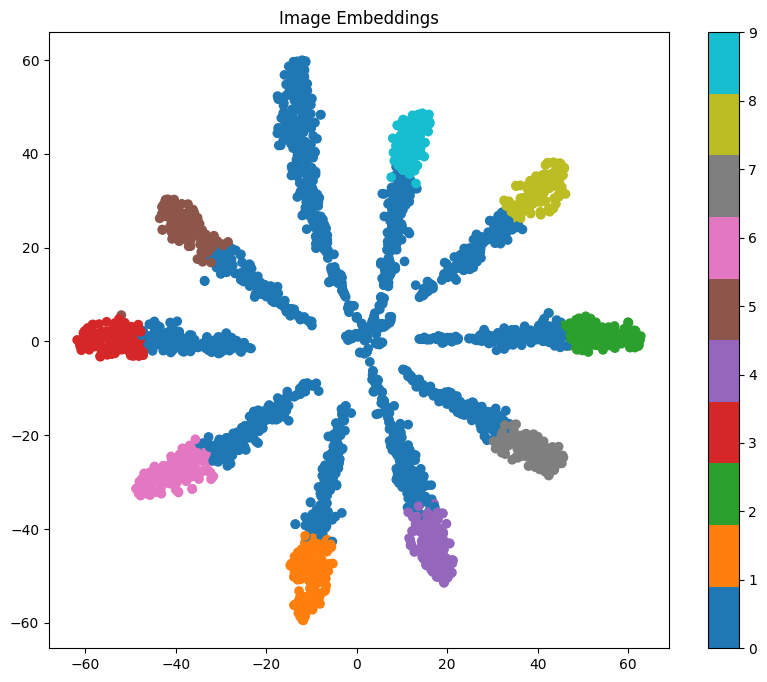

/home/mayur/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


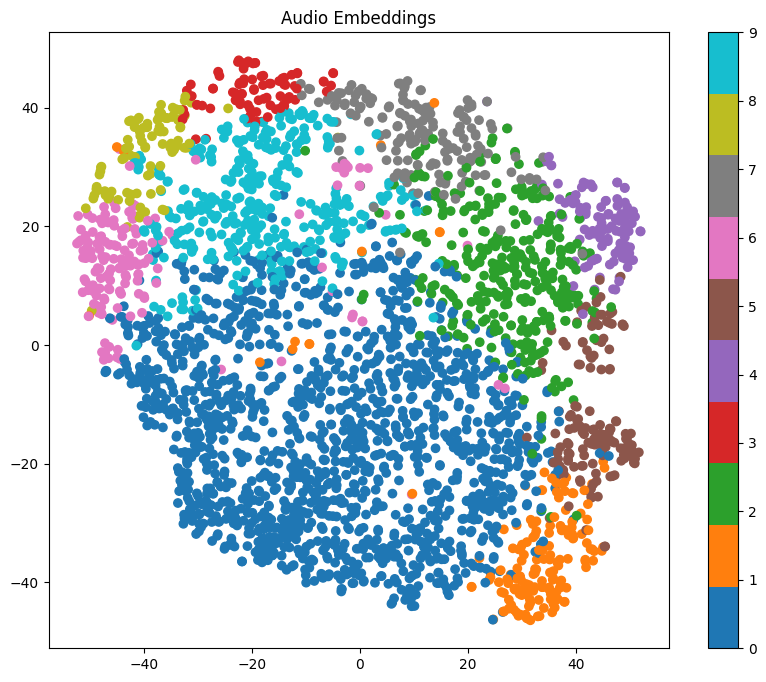

In [33]:
#print(f"Experimenting with num_conv_layers=2, kernel_size=3, dropout_rate=0.2")
model = AudioImageModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
A = ModelTrainandVal(model, train_loader_audio_image, val_loader_audio_image, loss_func, optimizer)
A.train_model()
# _,accuracy = A.evaluate_model()

In [34]:
def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for audio_test, image_test in test_loader:
            outputs, _, _ = model(audio_test, image_test)
            _, predicted = torch.max(outputs, 1)
            print(predicted)
            predictions.extend(predicted.tolist())
    return predictions

In [35]:
# If only state dictionary was saved
predictions = predict(model, test_loader_audio_image)

tensor([1, 2, 2, 5, 3, 5, 0, 6, 1, 4, 8, 0, 6, 9, 1, 8, 7, 7, 5, 4, 6, 7, 7, 5,
        3, 1, 9, 1, 6, 4, 1, 0])
tensor([2, 3, 6, 0, 0, 2, 0, 7, 8, 0, 5, 4, 2, 9, 7, 8, 9, 0, 3, 0, 9, 8, 6, 2,
        1, 1, 5, 1, 6, 9, 8, 5])
tensor([9, 4, 0, 1, 4, 4, 5, 5, 6, 3, 3, 3, 3, 6, 4, 2, 2, 9, 7, 2, 6, 3, 6, 9,
        8, 6, 5, 0, 2, 0, 1, 9])
tensor([9, 5, 9, 8, 9, 2, 4, 9, 5, 9, 6, 2, 3, 2, 6, 3, 6, 6, 2, 5, 1, 4, 1, 5,
        6, 4, 3, 5, 2, 1, 9, 4])
tensor([3, 7, 1, 2, 1, 2, 3, 3, 9, 9, 7, 7, 2, 6, 7, 3, 0, 6, 9, 8, 1, 0, 9, 8,
        4, 4, 8, 7, 2, 6, 3, 7])
tensor([5, 0, 5, 3, 0, 5, 0, 2, 5, 3, 5, 1, 5, 4, 2, 2, 6, 2, 6, 0, 2, 7, 9, 5,
        1, 2, 8, 4, 3, 5, 3, 4])
tensor([1, 5, 3, 2, 2, 2, 0, 4, 6, 1, 1, 5, 6, 3, 0, 8, 2, 5, 2, 5, 4, 7, 1, 6,
        2, 9, 6, 0, 8, 8, 4, 1])
tensor([3, 9, 1, 7, 1, 7, 8, 6, 0, 4, 1, 6, 0, 3, 4, 5, 1, 2, 5, 9, 3, 2, 0, 9,
        6, 8, 9, 3, 4, 2, 7, 5])
tensor([6, 6, 6, 1, 5, 6, 4, 4, 4, 8, 8, 1, 2, 0, 4, 6, 2, 9, 0, 6, 5, 9, 1, 9,
        1, 9, 4,

In [36]:
print(predictions)

[1, 2, 2, 5, 3, 5, 0, 6, 1, 4, 8, 0, 6, 9, 1, 8, 7, 7, 5, 4, 6, 7, 7, 5, 3, 1, 9, 1, 6, 4, 1, 0, 2, 3, 6, 0, 0, 2, 0, 7, 8, 0, 5, 4, 2, 9, 7, 8, 9, 0, 3, 0, 9, 8, 6, 2, 1, 1, 5, 1, 6, 9, 8, 5, 9, 4, 0, 1, 4, 4, 5, 5, 6, 3, 3, 3, 3, 6, 4, 2, 2, 9, 7, 2, 6, 3, 6, 9, 8, 6, 5, 0, 2, 0, 1, 9, 9, 5, 9, 8, 9, 2, 4, 9, 5, 9, 6, 2, 3, 2, 6, 3, 6, 6, 2, 5, 1, 4, 1, 5, 6, 4, 3, 5, 2, 1, 9, 4, 3, 7, 1, 2, 1, 2, 3, 3, 9, 9, 7, 7, 2, 6, 7, 3, 0, 6, 9, 8, 1, 0, 9, 8, 4, 4, 8, 7, 2, 6, 3, 7, 5, 0, 5, 3, 0, 5, 0, 2, 5, 3, 5, 1, 5, 4, 2, 2, 6, 2, 6, 0, 2, 7, 9, 5, 1, 2, 8, 4, 3, 5, 3, 4, 1, 5, 3, 2, 2, 2, 0, 4, 6, 1, 1, 5, 6, 3, 0, 8, 2, 5, 2, 5, 4, 7, 1, 6, 2, 9, 6, 0, 8, 8, 4, 1, 3, 9, 1, 7, 1, 7, 8, 6, 0, 4, 1, 6, 0, 3, 4, 5, 1, 2, 5, 9, 3, 2, 0, 9, 6, 8, 9, 3, 4, 2, 7, 5, 6, 6, 6, 1, 5, 6, 4, 4, 4, 8, 8, 1, 2, 0, 4, 6, 2, 9, 0, 6, 5, 9, 1, 9, 1, 9, 4, 0, 3, 0, 2, 5, 3, 6, 6, 5, 5, 6, 0, 6, 0, 4, 0, 5, 1, 1, 7, 6, 6, 7, 9, 9, 2, 5, 3, 6, 0, 9, 3, 4, 4, 8, 4, 7, 2, 2, 1, 1, 0, 4, 1, 2, 1, 6, 1, 9, 7, 

In [37]:
print(len(predictions))

10000


In [38]:
y_pred = np.array(predictions)

print(y_pred)

import pandas as pd

final_inference = pd.DataFrame({
    'row_id': np.arange(10000),
    'label' : y_pred.reshape(10000,)
})

final_inference.to_csv('../Predictions/Arunachalam_Venkatachalam_preds_model_high_overall_1.csv', index=False)

[1 2 2 ... 2 2 3]


In [39]:
# If only state dictionary was saved
model_state_dict = torch.load('../Models/model_high_best_1.pt')
model = AudioImageModel()  # Create a new instance of your model
model.load_state_dict(model_state_dict)
predictions = predict(model, test_loader_audio_image)

tensor([1, 2, 2, 5, 3, 5, 0, 6, 1, 4, 8, 0, 6, 9, 1, 8, 7, 7, 5, 4, 6, 7, 7, 5,
        3, 1, 9, 1, 6, 4, 1, 0])
tensor([2, 3, 6, 0, 0, 2, 0, 7, 8, 0, 5, 4, 2, 9, 7, 8, 9, 0, 3, 0, 9, 8, 6, 2,
        1, 1, 5, 1, 6, 9, 8, 5])
tensor([9, 4, 0, 1, 4, 4, 5, 5, 6, 3, 3, 3, 3, 6, 4, 2, 2, 9, 7, 2, 6, 3, 6, 9,
        8, 6, 5, 0, 2, 0, 1, 9])
tensor([9, 5, 9, 8, 9, 2, 4, 9, 5, 9, 6, 2, 3, 2, 6, 3, 6, 6, 2, 5, 1, 4, 1, 5,
        6, 4, 3, 5, 2, 1, 9, 4])
tensor([3, 7, 1, 2, 1, 2, 3, 3, 9, 9, 7, 7, 2, 6, 7, 3, 0, 6, 9, 8, 1, 0, 9, 8,
        4, 4, 8, 7, 2, 6, 3, 7])
tensor([5, 0, 5, 5, 0, 5, 0, 2, 5, 3, 5, 1, 5, 4, 2, 2, 6, 2, 6, 0, 2, 7, 9, 5,
        1, 2, 8, 4, 3, 5, 3, 4])
tensor([1, 5, 3, 2, 2, 2, 0, 4, 6, 1, 1, 5, 6, 3, 0, 8, 2, 5, 2, 5, 4, 7, 1, 6,
        2, 9, 6, 0, 8, 8, 4, 1])
tensor([3, 9, 1, 7, 1, 7, 8, 6, 0, 4, 1, 6, 0, 3, 4, 5, 1, 2, 5, 9, 3, 2, 0, 9,
        6, 8, 9, 3, 4, 2, 7, 5])
tensor([6, 6, 6, 1, 5, 6, 4, 4, 4, 8, 8, 1, 2, 0, 4, 6, 2, 9, 0, 6, 5, 9, 1, 9,
        1, 9, 4,

In [40]:
print(predictions)

[1, 2, 2, 5, 3, 5, 0, 6, 1, 4, 8, 0, 6, 9, 1, 8, 7, 7, 5, 4, 6, 7, 7, 5, 3, 1, 9, 1, 6, 4, 1, 0, 2, 3, 6, 0, 0, 2, 0, 7, 8, 0, 5, 4, 2, 9, 7, 8, 9, 0, 3, 0, 9, 8, 6, 2, 1, 1, 5, 1, 6, 9, 8, 5, 9, 4, 0, 1, 4, 4, 5, 5, 6, 3, 3, 3, 3, 6, 4, 2, 2, 9, 7, 2, 6, 3, 6, 9, 8, 6, 5, 0, 2, 0, 1, 9, 9, 5, 9, 8, 9, 2, 4, 9, 5, 9, 6, 2, 3, 2, 6, 3, 6, 6, 2, 5, 1, 4, 1, 5, 6, 4, 3, 5, 2, 1, 9, 4, 3, 7, 1, 2, 1, 2, 3, 3, 9, 9, 7, 7, 2, 6, 7, 3, 0, 6, 9, 8, 1, 0, 9, 8, 4, 4, 8, 7, 2, 6, 3, 7, 5, 0, 5, 5, 0, 5, 0, 2, 5, 3, 5, 1, 5, 4, 2, 2, 6, 2, 6, 0, 2, 7, 9, 5, 1, 2, 8, 4, 3, 5, 3, 4, 1, 5, 3, 2, 2, 2, 0, 4, 6, 1, 1, 5, 6, 3, 0, 8, 2, 5, 2, 5, 4, 7, 1, 6, 2, 9, 6, 0, 8, 8, 4, 1, 3, 9, 1, 7, 1, 7, 8, 6, 0, 4, 1, 6, 0, 3, 4, 5, 1, 2, 5, 9, 3, 2, 0, 9, 6, 8, 9, 3, 4, 2, 7, 5, 6, 6, 6, 1, 5, 6, 4, 4, 4, 8, 8, 1, 2, 0, 4, 6, 2, 9, 0, 6, 5, 9, 1, 9, 1, 9, 4, 0, 3, 0, 2, 5, 3, 6, 6, 5, 5, 6, 0, 6, 0, 4, 0, 5, 1, 1, 7, 6, 6, 7, 9, 9, 2, 5, 3, 6, 0, 9, 3, 4, 4, 8, 4, 7, 2, 2, 1, 1, 0, 4, 1, 2, 1, 6, 1, 9, 7, 

In [41]:
print(len(predictions))

10000


In [42]:
y_pred = np.array(predictions)

print(y_pred)

import pandas as pd

final_inference = pd.DataFrame({
    'row_id': np.arange(10000),
    'label' : y_pred.reshape(10000,)
})

final_inference.to_csv('../Predictions/Arunachalam_Venkatachalam_preds_model_high_best_1.csv', index=False)

[1 2 2 ... 2 2 3]


In [43]:
print(torch.cuda.is_available())

False
